# Data Insights

This notebook contains some statistical data analysis of the data.

It should help understand what's in the data and some basic interaction between the variables.

**Contents:**
- Variables Description
    1. Numeric variables
    2. Categorical variables
- Bivariate Correlations

In [1]:
import numpy as np       # Vectorized operations
import pandas as pd      # Data frames manipulation
from scipy import stats  # Statistical methods
np.random.seed(42)       # Set seed so the tests results are the same

# Plots modules
import matplotlib.pyplot as plt
import dexplot as dxp
import seaborn as sns
sns.set_style('whitegrid')

In [2]:
## Import the training and test data
col_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship',
             'race','sex','capital-gain','capital-loss','hours-per-week','native-country','class']

train = pd.read_csv('../data/adult.data', sep=', ', names=col_names, engine='python')
test = pd.read_csv('../data/adult.test', sep=', ', names=col_names, engine='python')
test = test.iloc[1:, :]            # There's a line with no information
test['age'] = test.age.apply(int)  # For some reason, the age-column in test was imported as character

# Replace '?' by missing values
train = train.replace('?', np.nan).dropna()
test = test.replace('?', np.nan)

# Regroup in one dataset
train['sample'] = 'train'; test['sample'] = 'test'
data = train.append(test) 

# Print information
data.info(); data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46443 entries, 0 to 16281
Data columns (total 16 columns):
age               46443 non-null int64
workclass         45480 non-null object
fnlwgt            46443 non-null float64
education         46443 non-null object
education-num     46443 non-null float64
marital-status    46443 non-null object
occupation        45477 non-null object
relationship      46443 non-null object
race              46443 non-null object
sex               46443 non-null object
capital-gain      46443 non-null float64
capital-loss      46443 non-null float64
hours-per-week    46443 non-null float64
native-country    46169 non-null object
class             46443 non-null object
sample            46443 non-null object
dtypes: float64(5), int64(1), object(10)
memory usage: 4.3+ MB


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class,sample
0,39,State-gov,77516.0,Bachelors,13.0,Never-married,Adm-clerical,Not-in-family,White,Male,2174.0,0.0,40.0,United-States,<=50K,train
1,50,Self-emp-not-inc,83311.0,Bachelors,13.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,13.0,United-States,<=50K,train
2,38,Private,215646.0,HS-grad,9.0,Divorced,Handlers-cleaners,Not-in-family,White,Male,0.0,0.0,40.0,United-States,<=50K,train
3,53,Private,234721.0,11th,7.0,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0.0,0.0,40.0,United-States,<=50K,train
4,28,Private,338409.0,Bachelors,13.0,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0.0,0.0,40.0,Cuba,<=50K,train


There are around 7.5% of observation with one or more missing values for both training and test sample. The data types and categories are exactly as defined by the data documentation.

---
## Variables Description
In this first part, I am describing each variable's distribution, and I am testing if the distributions are significantly different for the training and the test sets. 

### 1. Numeric Variables
For the numeric variables, I am first describing them by some basic statistics: the minimum value, the maximum value, the first, median and third quartiles, the mean and the standard deviation.  

*note*: education will be covered with the categorical variables. About the fnlwgt, those are final weights used by the Census Bureau to control the demographic balance of the sample. I might or might not use them in the detection model, but I won't treat them as covariates.

In [3]:
## Variable Description
num_columns = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
data[num_columns].describe()

,age,capital-gain,capital-loss,hours-per-week
count,46443.000000,46443.000000,46443.000000,46443.000000
mean,38.553431,1088.466249,88.206597,40.742286
std,13.390262,7469.002710,403.876248,12.159956
min,17.000000,0.000000,0.000000,1.000000
25%,28.000000,0.000000,0.000000,40.000000
50%,37.000000,0.000000,0.000000,40.000000
75%,47.000000,0.000000,0.000000,45.000000
max,90.000000,99999.000000,4356.000000,99.000000


Let's describe the distribution for **age**:
- The youngest respondents are 17 years old (`min`), and the oldest are 90 years old (`max`). The range is 73 years.  
Those might not reflect the real age of the respondents and might be the minimum/maximum values that people can answer.
- On average, the respondents are 38.6 yo (`mean` for training, 38 years and 8 months) and the standard deviation is 13.6 years (`std`).
- 25% of the respondent are less or equal to 28 yo, and 25% are more or equal to 48 yo.
- In particular, half of the respondents are younger than 37 yo. 

We can see in particular that most respondents have not reported any **capital gain** nor **loss**: for each variable, at least 75% of the respondents have 0 USD. However, the maximum value is really high, 99,999 USD for capital gain, and 4,356 USD for capital loss. The mean is high because of those unusual values and I would advise again using the mean for those variables as it is not robust.

Another interesting fact is that at least 25% of the respondents declared working 40 **hours per week**, and more than half are working between 40 and 45 hours a week. The lowest value you can declare seems to be 1 hour, and the highest value is 99 hours. Like for the age, those might be default values, meaning that you cannot declare 0 hours nor can you declare more than 99 hours.

___
It is important to know for sure that the covariates are identically distributed for both datasets, training and test. Indeed, it would be useless to train a model on data only covering half the actual values each variable can take.

I am ploting the estimated density functions for both the training and the test sets. It gives a better overview of the data distribution than some isolated quantiles.  
I am then performing the Kolmogorov-Smirnov test on the two samples. This is a two-sided test for the null hypothesis that 2 independent samples are drawn from the same continuous distribution.

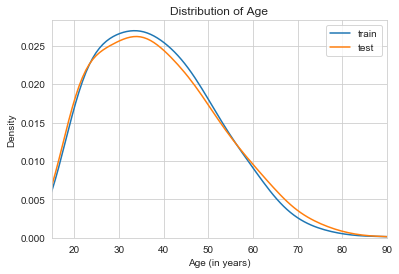

Ks_2sampResult(statistic=0.01862407834008617, pvalue=0.0012822456500552555)

In [4]:
## Age Distribution
sns.kdeplot(np.array(train.age), bw=4, label='train')
sns.kdeplot(np.array(test.age), bw=4, label='test')
plt.xlabel('Age (in years)'); plt.xlim(15, 90); plt.ylabel('Density')
plt.title('Distribution of Age')
plt.show()

# KM-test
stats.ks_2samp(train.age, test.age)

We can see on the density plot that the respondents are mainly distributed between 17 and 60 years old. The distribution has an heavy tail, meaning that most of its population is quite young, but the older people have a far greater age than average, creating asymetry.

The two density curves are very similar, which corrobore the KM-test: with a p-value of 0.45 >> 0.05, we don't have enough evidence that the two distributions are different. In other words, the training and the test samples for age are identically distributed.

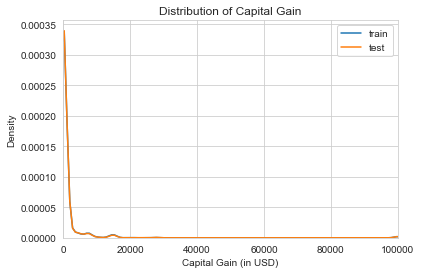

Ks_2sampResult(statistic=0.0038642751047176516, pvalue=0.9974060502796676)

In [5]:
## Capital Gain Distribution
sns.kdeplot(np.array(train['capital-gain']), bw=1000, label='train')
sns.kdeplot(np.array(test['capital-gain']), bw=1000, label='test')
plt.xlabel('Capital Gain (in USD)'); plt.xlim(0, 100000); plt.ylabel('Density')
plt.title('Distribution of Capital Gain')
plt.show()

# KM-test
stats.ks_2samp(train['capital-gain'], test['capital-gain'])

We can clearly see on the density plot that most of the respondents have not declared any capital gain. The distribution has a very long tail, to \\$100,000, with a slight bump at the upper range, meaning that quite a few people had very high capital gain.

The two density curves are very similar, and the km-test states that the two distributions are in fact similar, with a p-value of almost 1.

In [6]:
train['capital-gain'].value_counts()[:7]/len(train)

0        0.915854
15024    0.011173
7688     0.008952
7298     0.007957
99999    0.004907
3103     0.003117
5178     0.003017
Name: capital-gain, dtype: float64

Looking at the 7 most popular sums for capital gain, we notice than 92% of the respondents declared \\$0, while 0.5% declared the maximum value of \\$99,999, which explains the bump at that value.

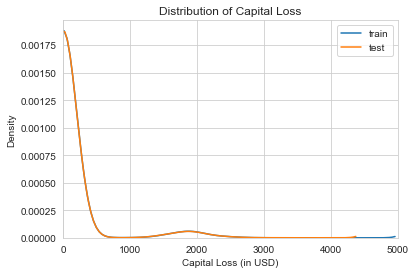

Ks_2sampResult(statistic=0.000995172716797943, pvalue=1.0)

Proportion of respondents with $0 capital loss: 95.3%


In [7]:
## Capital Loss Distribution
sns.kdeplot(np.array(train['capital-loss']), bw=200, label='train')
sns.kdeplot(np.array(test['capital-loss']), bw=200, label='test')
plt.xlabel('Capital Loss (in USD)'); plt.xlim(0, 5000); plt.ylabel('Density')
plt.title('Distribution of Capital Loss')
plt.show()

# KM-test
print(stats.ks_2samp(train['capital-loss'], test['capital-loss']))

print("\nProportion of respondents with $0 capital loss: %.1f%%" %(np.mean(train['capital-loss'] == 0)*100))

We can clearly see on the density plot that most of the respondents have not declared any capital loss (in fact, 95%). The distribution has a very long tail, with a slight bump around \\$2,000, meaning that quite a few people had high capital loss.

The two density curves are very similar, and the km-test states that the two distributions are in fact similar, with a p-value of 1.

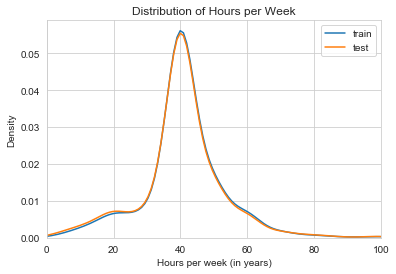

Ks_2sampResult(statistic=0.01861043663156367, pvalue=0.0012961259484972662)

In [8]:
## Hours per Week Distribution
sns.kdeplot(np.array(train['hours-per-week']), bw=4, label='train')
sns.kdeplot(np.array(test['hours-per-week']), bw=4, label='test')
plt.xlabel('Hours per week (in years)'); plt.xlim(0, 100); plt.ylabel('Density')
plt.title('Distribution of Hours per Week')
plt.show()

# KM-test
stats.ks_2samp(train['hours-per-week'], test['hours-per-week'])

We can see on the density plot that the respondents are mainly distributed between 30 and 55 hours a week, with a very high density at 40 hours. The slope between 0 and 20 shows that there are quite a lot of people working few hours a week, most likely part-timers. On the other side, the slope decreases quickly, showing that very few people works a lot of hours.

The two density curves are very similar, and the km-test states that the two distributions are in fact similar, with a p-value of 0.97 >> 0.05.

---

### 2. Categorical Variables
For the categorical variables, I am comparing the proportion for each category. 

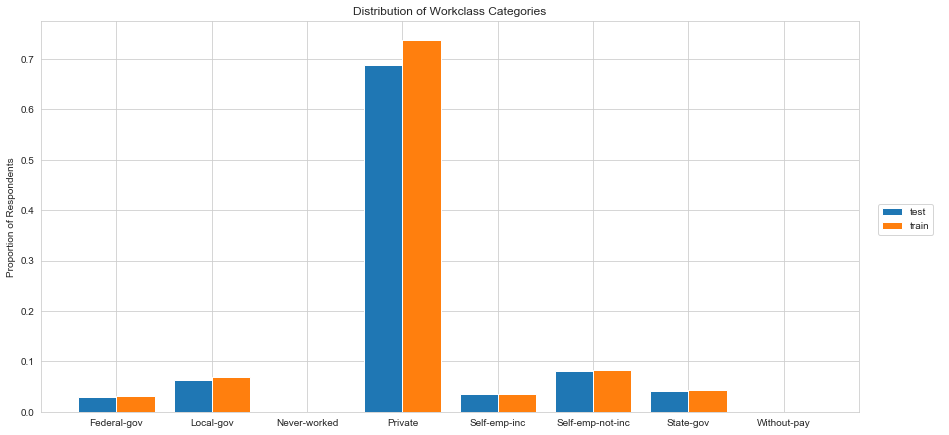

In [9]:
## Workclass categories
dxp.aggplot(agg='workclass', data=data, hue='sample', normalize='sample')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Workclass Categories')
plt.show()

Most of the respondents are working in the **private sector**, nearly 70%.  
The two categories "Never-worked" and "Without-pay" have very few respondents: around 20 each overall.

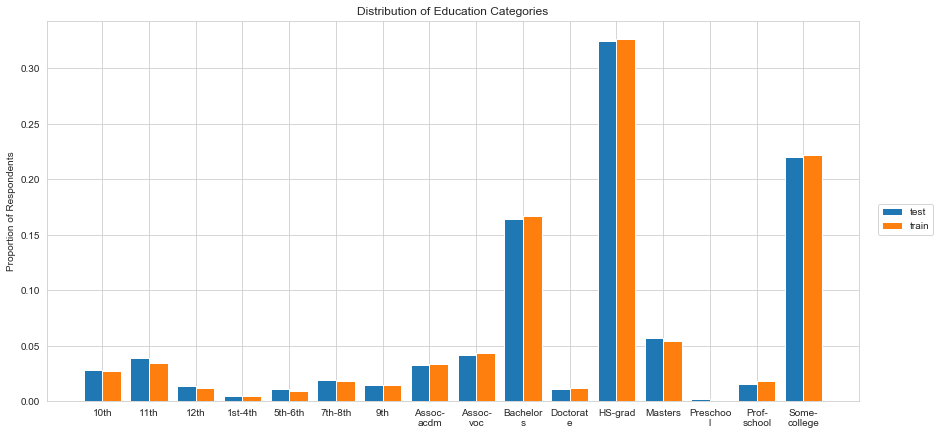

In [10]:
## Education categories
dxp.aggplot(agg='education', data=data, hue='sample', normalize='sample')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Education Categories')
plt.show()

The most represented education level is "HS-grad" with more than 30% of the respondents, followed by "Some-college" (22%) and "Bachelors" (16%).  
The lowest level of education have very few respondents: 509 for 5th and 6th gardes, 247 for 1st to 4th grades, and only 83 for Preschool. 

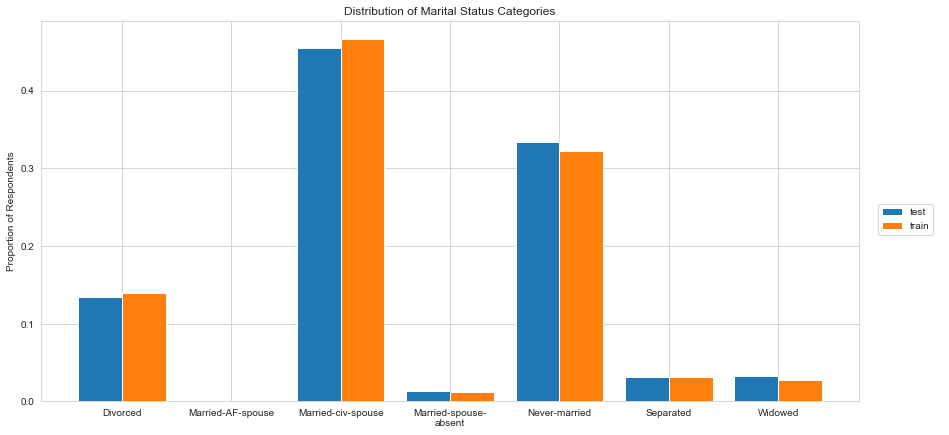

In [11]:
## Marital Status categories
dxp.aggplot(agg='marital-status', data=data, hue='sample', normalize='sample')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Marital Status Categories')
plt.show()

The main category is "Married - Civilian" with more than 45% of the respondents, followed by "Never married" (33%).  
The least used category is "Married - Armed Forces" with only 37 respondents.

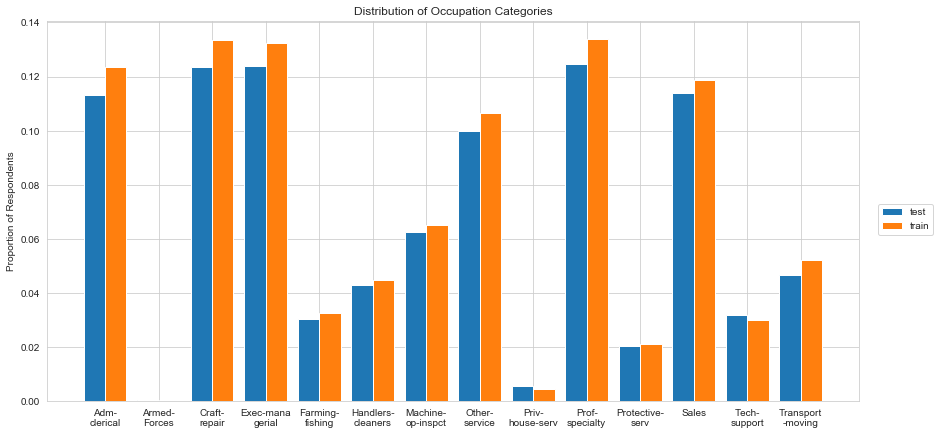

In [12]:
## Occupation categories
dxp.aggplot(agg='occupation', data=data, hue='sample', normalize='sample')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Occupation Categories')
plt.show()

The most-represented occupations are "Prof-specialty", "Craft-repair" and "Executive Managerial", each with a little more than 12% of the respondents.  
The least represented occupations are "Armed Forces" and "Private House Services", both less than 1% respondents.

In [13]:
## Race categories
print(train.race.value_counts(normalize=True))
test.race.value_counts(normalize=True)

White                 0.859790
Black                 0.093396
Asian-Pac-Islander    0.029673
Amer-Indian-Eskimo    0.009482
Other                 0.007659
Name: race, dtype: float64


White                 0.856581
Black                 0.095879
Asian-Pac-Islander    0.029482
Amer-Indian-Eskimo    0.009766
Other                 0.008292
Name: race, dtype: float64

The most-represented race is "White", with 85% of the respondents.  
The least-represented are Amer-Indians and Eskimos with less than 1%. Nearly 1% of the respondents are from minorities that don't have their own category.

In [14]:
## Sex categories
print(train.sex.value_counts(normalize=True))
test.sex.value_counts(normalize=True)

Male      0.675685
Female    0.324315
Name: sex, dtype: float64


Male      0.667035
Female    0.332965
Name: sex, dtype: float64

67% of the respondents are men, and 33% are women.

In [15]:
## Native countries
print(train['native-country'].value_counts(normalize=True)[:3])
test['native-country'].value_counts(normalize=True)[:3]

United-States    0.911876
Mexico           0.020224
Philippines      0.006233
Name: native-country, dtype: float64


United-States    0.915974
Mexico           0.019242
Philippines      0.006060
Name: native-country, dtype: float64

More than 90% of the respondents were born in the USA. 2% were born in Mexico. The other countries count for less than 1% each.

---
For each of the above variables, the proportion of respondents for each category are fairly similar between the training and test sets.  

Some categories have very few respondents, so I might have to group similar categories together. Especially for the native countries, I might group by continents.

## Bivariate Correlations
### 1. With the Response
In this part, I am looking at the direct effect of each covariate on the response variable: whether a respondent have more than \\$50k.

I am using again the Kolmogorov-Smirnov test to compare the distribution of each numeric variable under each class, and I am comparing the proportion for each level of the categorical variables.

I prefer to work with the training set only, so I won't biased my analysis.

In [16]:
high = train[train['class'] == '>50K']
low = train[train['class'] == '<=50K']

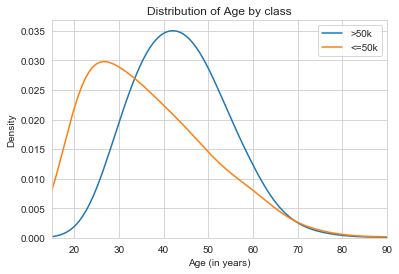

Ks_2sampResult(statistic=0.31786867969419186, pvalue=0.0)

In [17]:
## Age Distribution
sns.kdeplot(np.array(high.age), bw=4, label='>50k')
sns.kdeplot(np.array(low.age), bw=4, label='<=50k')
plt.xlabel('Age (in years)'); plt.xlim(15, 90); plt.ylabel('Density')
plt.title('Distribution of Age by class'); plt.show()

# KM-test
stats.ks_2samp(high.age, low.age)

The age distribution of people in the ">50k" class is significantly higher than for the "<=50k" (p-value = 0 << 0.05).   
In particular, the age peaks at around 40 yo for the higher class, and at around 25 yo for the lower class. Plus, the distribution for people earning less is obviously asymetric, with a heavy tail in the upper values.   
I expect the age will have a great importance in predicting the class.

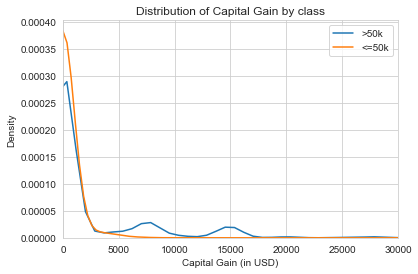

Ks_2sampResult(statistic=0.19025750420527865, pvalue=2.677571019915006e-178)

In [18]:
## Capital Gain Distribution
sns.kdeplot(np.array(high['capital-gain']), bw=1000, label='>50k')
sns.kdeplot(np.array(low['capital-gain']), bw=1000, label='<=50k')
plt.xlabel('Capital Gain (in USD)'); plt.xlim(0, 30000); plt.ylabel('Density')
plt.title('Distribution of Capital Gain by class'); plt.show()

# KM-test
stats.ks_2samp(high['capital-gain'], low['capital-gain'])

The two distributions for capital gain are significantly distinct (p-value << 0.5).  
In particular, the distribution for "<=50k" is more dense around 0 than the one for "<50k", and has less density on the upper tail.

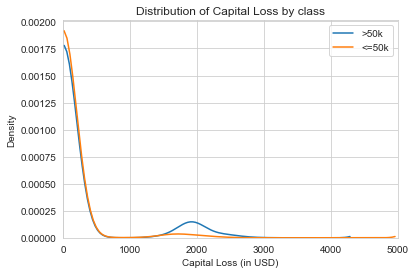

Ks_2sampResult(statistic=0.07922624801283151, pvalue=2.866892931937988e-31)

In [19]:
## Capital Loss Distribution
sns.kdeplot(np.array(high['capital-loss']), bw=200, label='>50k')
sns.kdeplot(np.array(low['capital-loss']), bw=200, label='<=50k')
plt.xlabel('Capital Loss (in USD)'); plt.xlim(0, 5000)
plt.ylabel('Density')
plt.title('Distribution of Capital Loss by class')
plt.show()

# KM-test
stats.ks_2samp(high['capital-loss'], low['capital-loss'])

The two distributions for capital loss are significantly distinct (p-value << 0.5).  
In particular, the distribution for "<=50k" is slightly more dense around 0 than the one for "<50k", and has less density on the upper tail.

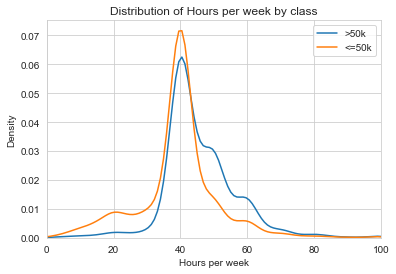

Ks_2sampResult(statistic=0.25786488115040374, pvalue=0.0)

In [20]:
## Hours per week Distribution
sns.kdeplot(np.array(high['hours-per-week']), bw=3, label='>50k')
sns.kdeplot(np.array(low['hours-per-week']), bw=3, label='<=50k')
plt.xlabel('Hours per week'); plt.xlim(0, 100)
plt.ylabel('Density')
plt.title('Distribution of Hours per week by class')
plt.show()

# KM-test
stats.ks_2samp(high['hours-per-week'], low['hours-per-week'])

The distribution for hours-per-week of people in the ">50k" class is significantly higher than for the "<=50k" (p-value = 0 << 0.05).   
The density still peaks at around 40 hours for both class, but the lower tail is heavier for the lower class, and the upper tail is heavier for the upper class.  
I expect the hours-per-week will have a great importance in predicting the class.

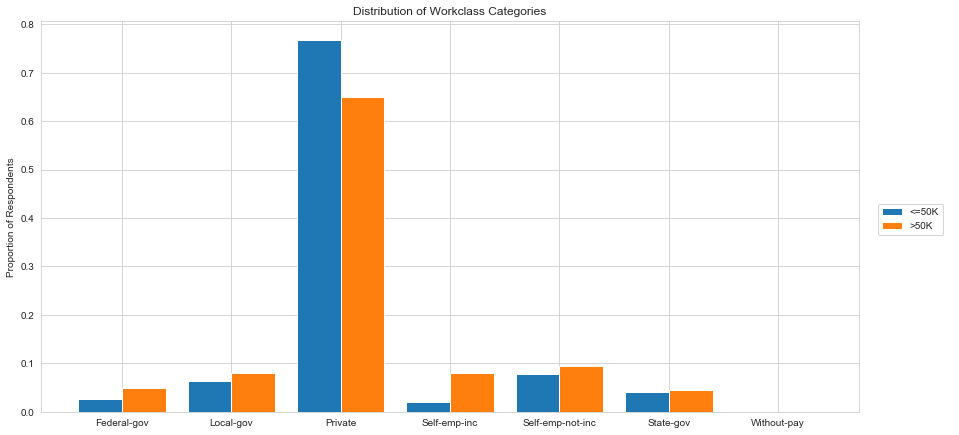

(Chi-squared=804.157527, p-value=1.9460955892391565e-170)


In [21]:
## Workclass categories
dxp.aggplot(agg='workclass', data=train, hue='class', normalize='class')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Workclass Categories')
plt.show()

# Chi-square contigency test
names = data.workclass[data.workclass.notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high.workclass == i)))[:-1], 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low.workclass == i)))[:-1]])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

The two distributions for workclass are significantly distinct (p-value << 0.5).  
In particular, the private sector is over-represented amongst the class "<=50k", and the "self-employed-inc" is over-represnted amongst the ">50k".  

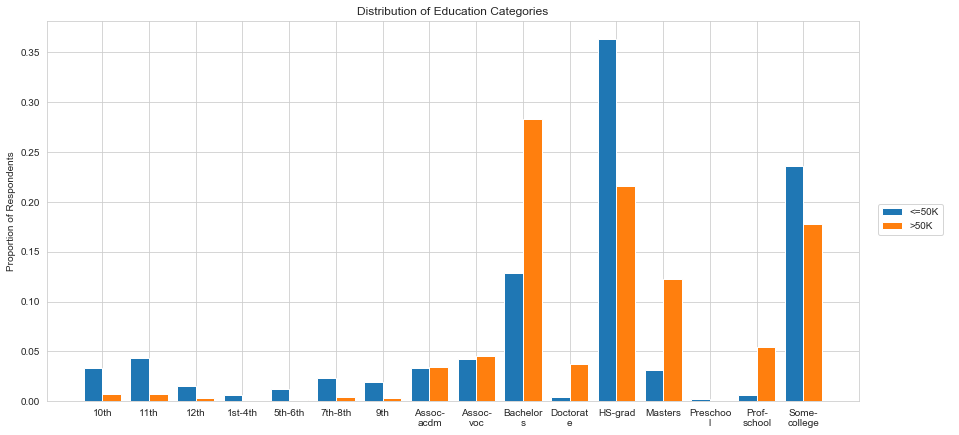

(Chi-squared=4070.381622, p-value=0.0)


In [22]:
## Education categories
dxp.aggplot(agg='education', data=train, hue='class', normalize='class')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Education Categories')
plt.show()

# Chi-square contigency test
names = data.education[data.education.notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high.education == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low.education == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

The two distributions for education are significantly distinct (p-value << 0.5).  
In particular, the class "<=50k" is over-represented among people that never finished high school (grade 12th and under), HS-grads, and college students.  
On the other hand, the class ">50k" is over-represented among Bachelors, Masters, Doctorants and Professional schools.

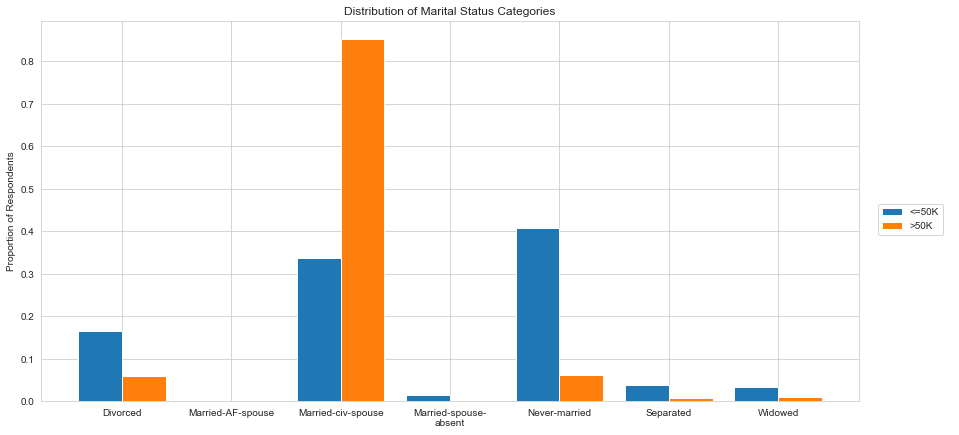

(Chi-squared=6061.747963, p-value=0.0)


In [23]:
## Marital Status categories
dxp.aggplot(agg='marital-status', data=train, hue='class', normalize='class')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Marital Status Categories')
plt.show()

# Chi-square contigency test
names = data['marital-status'][data['marital-status'].notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high['marital-status'] == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low['marital-status'] == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

The two distributions for marital status are significantly distinct (p-value << 0.5).  
In particular, the class ">50k" is over-represented among Married (civilians).  
On the other hand, the class "<=50k" is over-represented among all the other categories.

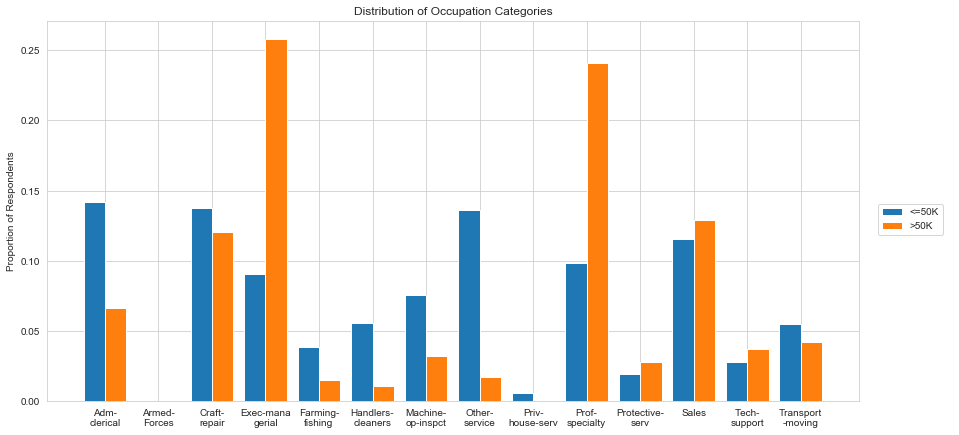

(Chi-squared=3687.620651, p-value=0.0)


In [24]:
## Occupation categories
dxp.aggplot(agg='occupation', data=train, hue='class', normalize='class')
plt.ylabel('Proportion of Respondents'); plt.xlabel('')
plt.title('Distribution of Occupation Categories')
plt.show()

# Chi-square contigency test
names = data.occupation[data.occupation.notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high.occupation == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low.occupation == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

The two distributions for Occupation are significantly distinct (p-value << 0.5).  
In particular, the class "<=50k" is over-represented among farmers, cleaners, and other services.  
On the other hand, the class ">50k" is over-represented among executive managers, professional specialists and salesmen.

In [25]:
## Race categories
print('Proportion for people in ">50k": '); print(high['race'].value_counts(normalize=True)); print("")
print('Proportion for people in "<=50k":'); print(low['race'].value_counts(normalize=True)); print("")

# Chi-square contigency test
names = data.race[data.race.notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high.race == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low.race == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

Proportion for people in ">50k": 
White                 0.910895
Black                 0.048748
Asian-Pac-Islander    0.033031
Amer-Indian-Eskimo    0.004529
Other                 0.002797
Name: race, dtype: float64

Proportion for people in "<=50k":
White                 0.842853
Black                 0.108193
Asian-Pac-Islander    0.028560
Amer-Indian-Eskimo    0.011124
Other                 0.009270
Name: race, dtype: float64

(Chi-squared=304.241374, p-value=1.3178285203762715e-64)


The two distributions for races are significantly distinct (p-value << 0.5).  
In particular, the class "<=50k" is over-represented among black people, and the class ">50k" is over-represented among white people.

In [26]:
## Sex categories
print('Proportion for people in ">50k": '); print(high['sex'].value_counts(normalize=True)); print("")
print('Proportion for people in "<=50k":'); print(low['sex'].value_counts(normalize=True)); print("")

# Chi-square contigency test
names = data.sex[data.sex.notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high.sex == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low.sex == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

Proportion for people in ">50k": 
Male      0.851891
Female    0.148109
Name: sex, dtype: float64

Proportion for people in "<=50k":
Male      0.617286
Female    0.382714
Name: sex, dtype: float64

(Chi-squared=1415.286404, p-value=1.00155254124934e-309)


The two distributions for sex are significantly distinct (p-value << 0.5).  
In particular, the class "<=50k" is over-represented among women and the class ">50k" is over-represented among men.

In [27]:
## Native Countries
print('Proportion for people in ">50k": '); print(high['native-country'].value_counts(normalize=True)[:6]); print("")
print('Proportion for people in "<=50k":'); print(low['native-country'].value_counts(normalize=True)[:6]); print("")

# Chi-square contigency test
names = data['native-country'][data['native-country'].notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high['native-country'] == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low['native-country'] == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

Proportion for people in ">50k": 
United-States    0.931673
Philippines      0.007991
Germany          0.005860
India            0.005328
Canada           0.004795
Mexico           0.004395
Name: native-country, dtype: float64

Proportion for people in "<=50k":
United-States    0.905315
Mexico           0.025470
Philippines      0.005650
Puerto-Rico      0.004282
El-Salvador      0.004017
Germany          0.003708
Name: native-country, dtype: float64

(Chi-squared=317.736675, p-value=6.22122194454428e-45)


The two distributions for native countries are significantly distinct (p-value << 0.5).  
In particular, the class "<=50k" is over-represented among people that were born in Mexico.  
On the other hand, the class ">50k" is over-represented among people born in the States, in Philippines, and in Germany.

---
Since most countries in the list have very few people, I decided to group them by geographical area:
- `north-america`: for the USA and Canada,
- `mexico`: stays alone
- `carribean`: groups all the islands in the Carribean sea and the Gulf of Mexico,
- `south-america`: groups all the countries in America, south from Mexico,
- `europe`: groups all European countries,
- `asia`: with countries from Asia and Indonesia.

In [28]:
## Native Continent
mapp = {'United-States':'north-america', 'Mexico':'mexico', 'Canada':'north-america', 'Outlying-US(Guam-USVI-etc)':'north-america', 
        'Cuba':'carribean', 'Puerto-Rico':'carribean', 'Dominican-Republic':'carribean', 'Haiti':'carribean', 'Jamaica':'carribean', 
        'Honduras':'south-america', 'Guatemala':'south-america', 'Nicaragua':'south-america', 'El-Salvador':'south-america', 'Trinadad&Tobago':'south-america', 'Peru':'south-america', 'Columbia':'south-america', 'Ecuador':'south-america', 
        'England':'europe', 'Holand-Netherlands':'europe', 'Ireland':'europe', 'Hungary':'europe', 'Greece':'europe', 'Scotland':'europe', 'Germany':'europe', 'Yugoslavia':'europe', 'Poland':'europe', 'Portugal':'europe', 'France':'europe', 'Italy':'europe', 
        'China':'asia', 'Hong':'asia', 'Japan':'asia', 'Philippines':'asia', 'India':'asia', 'Vietnam':'asia', 'Cambodia':'asia', 'Thailand':'asia', 'South':'asia' , 'Iran':'asia', 'Laos':'asia', 'Taiwan':'asia', 
        }
train['native-continent'] = train['native-country'].apply(lambda i: mapp[i])
high = train[train['class'] == '>50K']; low = train[train['class'] == '<=50K']
train['native-continent'].value_counts()

north-america    27625
asia               705
mexico             610
europe             493
carribean          390
south-america      339
Name: native-continent, dtype: int64

In [29]:
print('Proportion for people in ">50k": '); print(high['native-continent'].value_counts(normalize=True)); print("")
print('Proportion for people in "<=50k":'); print(low['native-continent'].value_counts(normalize=True)); print("")

# Chi-square contigency test
names = train['native-continent'][train['native-continent'].notnull()].unique()
obs = np.matrix([np.array(pd.Series(names).apply(lambda i: np.sum(high['native-continent'] == i))), 
                 np.array(pd.Series(names).apply(lambda i: np.sum(low['native-continent'] == i)))])
chisq, pval, dof, est = stats.chi2_contingency(obs)
print('(Chi-squared=%f, p-value=%s)' %(chisq, pval))

Proportion for people in ">50k": 
north-america    0.936468
asia             0.028903
europe           0.019845
carribean        0.007059
mexico           0.004395
south-america    0.003330
Name: native-continent, dtype: float64

Proportion for people in "<=50k":
north-america    0.909067
mexico           0.025470
asia             0.021541
europe           0.015185
carribean        0.014876
south-america    0.013861
Name: native-continent, dtype: float64

(Chi-squared=231.320296, p-value=5.574365504390853e-48)


Now we can see more clearly that the class "<=50k" is over-represented among people that were born in Mexico, on a Carribean island, or in South America.  
On the other hand, the class ">50k" is over-represented among people born in North America, in Europe, or in Asia.